# UMAP Visualization for Word2Vec

In [1]:
from pathlib import Path

from gensim.models import Word2Vec, KeyedVectors
import numpy as np
import pandas as pd
import plotnine as p9
import plydata as ply
import tensorflow as tf
import umap

## Preselect tokens for Projections

In [2]:
selected_year = "2010"
tokens_sampled = 5000

In [3]:
unaligned_models = list(Path(f"output/models/{selected_year}_model").glob("*model"))
aligned_models = list(Path(f"output/aligned_models/{selected_year}_model").glob("*kv"))
output_file_folder = Path("output/figure_data_and_figures/alignment_visualization")

In [4]:
np.random.seed(100)
total_matching_tokens = set()
for model_path in aligned_models:
    word_model_to_query = KeyedVectors.load(str(model_path))
    if len(total_matching_tokens) == 0:
        total_matching_tokens = set(word_model_to_query.vocab.keys())
    else:
        total_matching_tokens &= set(word_model_to_query.vocab.keys())
total_matching_tokens = list(total_matching_tokens)

In [5]:
total_words = len(total_matching_tokens)
token_indicies = np.random.choice(total_words, tokens_sampled)
selected_tokens = [total_matching_tokens[idx] for idx in token_indicies]

In [6]:
np.random.seed(100)
example_tok = np.random.choice(sorted(selected_tokens), size=1)[0]
example_tok

'probiotics'

## Unaligned

In [7]:
word_model_list = list()
for model_path in unaligned_models:
    year = model_path.stem.split("_")[0]
    word_model_list.append(model_path)

word_model_list = sorted(word_model_list, key=lambda x: int(x.stem.split("_")[1]))
word_model_list

[PosixPath('output/models/2010_model/2010_0_fulltext.model'),
 PosixPath('output/models/2010_model/2010_1_fulltext.model'),
 PosixPath('output/models/2010_model/2010_2_fulltext.model'),
 PosixPath('output/models/2010_model/2010_3_fulltext.model'),
 PosixPath('output/models/2010_model/2010_4_fulltext.model'),
 PosixPath('output/models/2010_model/2010_5_fulltext.model'),
 PosixPath('output/models/2010_model/2010_6_fulltext.model'),
 PosixPath('output/models/2010_model/2010_7_fulltext.model'),
 PosixPath('output/models/2010_model/2010_8_fulltext.model'),
 PosixPath('output/models/2010_model/2010_9_fulltext.model')]

In [8]:
word_vectors = []
unaligned_tokens = []
for idx, model_path in enumerate(word_model_list):
    word2vec_model = Word2Vec.load(str(model_path))
    word_vectors.append(word2vec_model.wv[selected_tokens])
    unaligned_tokens += selected_tokens

    # only use five models
    if idx > 4:
        break

In [9]:
tf.random.set_seed(100)
umap_model = umap.UMAP(
    verbose=True,
    metric="cosine",
    random_state=100,
    low_memory=True,
    n_neighbors=25,
    min_dist=0.99,
    n_epochs=50,
)
unaligned_model_embeddings = umap_model.fit_transform(np.vstack(word_vectors))

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.99, n_epochs=50, n_neighbors=25, random_state=101, verbose=True)
Sat May 14 15:01:41 2022 Construct fuzzy simplicial set
Sat May 14 15:01:41 2022 Finding Nearest Neighbors
Sat May 14 15:01:41 2022 Building RP forest with 14 trees
Sat May 14 15:01:42 2022 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
	 6  /  15
	 7  /  15
	Stopping threshold met -- exiting after 7 iterations
Sat May 14 15:01:55 2022 Finished Nearest Neighbor Search
Sat May 14 15:01:57 2022 Construct embedding



Sat May 14 15:02:04 2022 Finished embedding


In [10]:
unaligned_tok_df = (
    pd.DataFrame(unaligned_model_embeddings, columns=["umap1", "umap2"])
    >> ply.define(tok=unaligned_tokens)
    >> ply.define(
        year_label=(
            ["0"] * tokens_sampled
            + ["1"] * tokens_sampled
            + ["2"] * tokens_sampled
            + ["3"] * tokens_sampled
            + ["4"] * tokens_sampled
            + ["5"] * tokens_sampled
        )
    )
)
unaligned_tok_df >> ply.call(
    ".to_csv",
    f"{str(output_file_folder)}/unaligned_{selected_year}_umap_tokens.tsv",
    sep="\t",
    index=False,
)
unaligned_tok_df >> ply.slice_rows(10)

,umap1,umap2,tok,year_label
0,1.185876,12.890275,3.571,0
1,0.586471,11.832870,mc903,0
2,1.830472,12.088999,riskfactor,0
3,0.894690,11.010674,minicircle,0
4,3.272954,9.339231,vtach,0
5,0.260971,9.983262,gene_130749,0
6,0.227241,10.481217,gene_22221,0
7,2.402827,9.910058,preneoplasic,0
8,2.414830,13.832701,t(df,0
9,1.674093,11.334801,touchdown,0


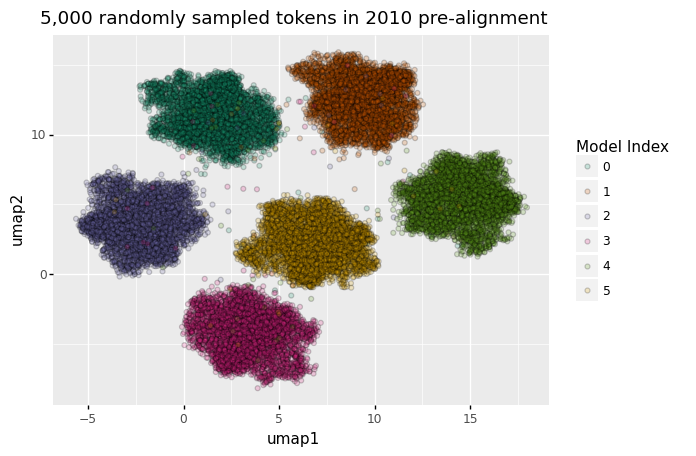

/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: output/figure_data_and_figures/unaligned_2010_plot.svg
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: output/figure_data_and_figures/unaligned_2010_plot.png


In [11]:
g = unaligned_tok_df >> (
    p9.ggplot()
    + p9.aes(x="umap1", y="umap2", fill="year_label")
    + p9.geom_point(alpha=0.2)
    + p9.scale_fill_brewer(type="qual", palette="Dark2")
    + p9.labs(
        title=f"{tokens_sampled:,} randomly sampled tokens in {selected_year} pre-alignment",
        fill="Model Index",
    )
)
print(g)
g.save(f"{str(output_file_folder)}/unaligned_{selected_year}_plot.svg")
g.save(f"{str(output_file_folder)}/unaligned_{selected_year}_plot.png", dpi=300)

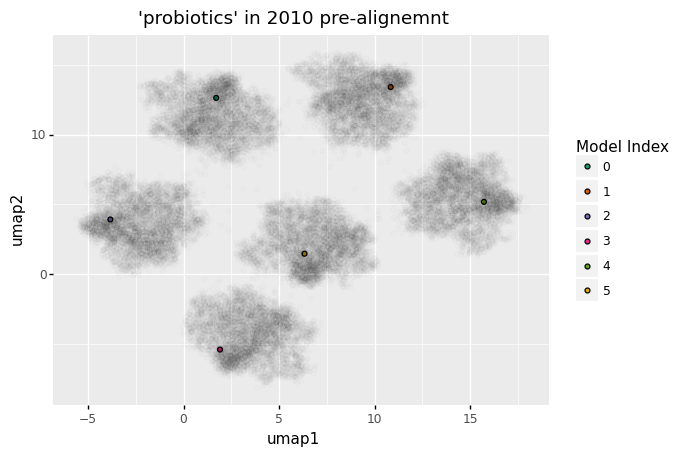

/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: output/figure_data_and_figures/unaligned_2010_probiotics_plot.svg
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: output/figure_data_and_figures/unaligned_2010_probiotics_plot.svg


In [12]:
g = (
    unaligned_tok_df
    >> ply.query(f"tok=='{example_tok}'")
    >> (
        p9.ggplot()
        + p9.aes(x="umap1", y="umap2", fill="year_label")
        + p9.geom_point()
        + p9.scale_fill_brewer(type="qual", palette="Dark2")
        + p9.geom_point(
            p9.aes(x="umap1", y="umap2"), data=unaligned_tok_df, fill="grey", alpha=0.01
        )
        + p9.labs(
            title=f"'{example_tok}' in {selected_year} pre-alignemnt",
            fill="Model Index",
        )
    )
)

print(g)
g.save(f"{str(output_file_folder)}/unaligned_{selected_year}_{example_tok}_plot.svg")
g.save(
    f"{str(output_file_folder)}/unaligned_{selected_year}_{example_tok}_plot.svg",
    dpi=300,
)

## Aligned

In [13]:
aligned_word_vectors = []
aligned_tokens = []
for idx, model_path in enumerate(aligned_models):
    word2vec_model = KeyedVectors.load(str(model_path))
    aligned_word_vectors.append(word2vec_model.wv[selected_tokens])
    aligned_tokens += selected_tokens

    # only use four models
    if idx > 4:
        break

/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/home/danich1/anaconda3/envs/biovec

In [14]:
umap_model = umap.UMAP(
    verbose=True,
    metric="cosine",
    random_state=101,
    low_memory=True,
    n_neighbors=25,
    min_dist=0.99,
    n_epochs=50,
)
aligned_model_embeddings = umap_model.fit_transform(np.vstack(aligned_word_vectors))

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.99, n_epochs=50, n_neighbors=25, random_state=101, verbose=True)
Sat May 14 15:02:29 2022 Construct fuzzy simplicial set
Sat May 14 15:02:29 2022 Finding Nearest Neighbors
Sat May 14 15:02:29 2022 Building RP forest with 14 trees
Sat May 14 15:02:29 2022 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
	 6  /  15
	Stopping threshold met -- exiting after 6 iterations
Sat May 14 15:02:32 2022 Finished Nearest Neighbor Search
Sat May 14 15:02:32 2022 Construct embedding



Sat May 14 15:02:41 2022 Finished embedding


In [15]:
aligned_tok_df = (
    pd.DataFrame(aligned_model_embeddings, columns=["umap1", "umap2"])
    >> ply.define(tok=aligned_tokens)
    >> ply.define(
        year_label=(
            ["0"] * tokens_sampled
            + ["1"] * tokens_sampled
            + ["2"] * tokens_sampled
            + ["3"] * tokens_sampled
            + ["4"] * tokens_sampled
            + ["5"] * tokens_sampled
        )
    )
)
aligned_tok_df >> ply.call(
    ".to_csv",
    f"{str(output_file_folder)}/aligned_{selected_year}_umap_tokens.tsv",
    sep="\t",
    index=False,
)
aligned_tok_df >> ply.slice_rows(10)

,umap1,umap2,tok,year_label
0,10.462533,5.479509,3.571,0
1,7.619193,8.163077,mc903,0
2,7.487350,3.080544,riskfactor,0
3,21.996948,-1.405238,minicircle,0
4,13.231977,4.132542,vtach,0
5,12.786169,10.623718,gene_130749,0
6,23.188116,-1.594649,gene_22221,0
7,9.316363,6.556396,preneoplasic,0
8,8.585002,3.365388,t(df,0
9,9.588791,-4.184581,touchdown,0


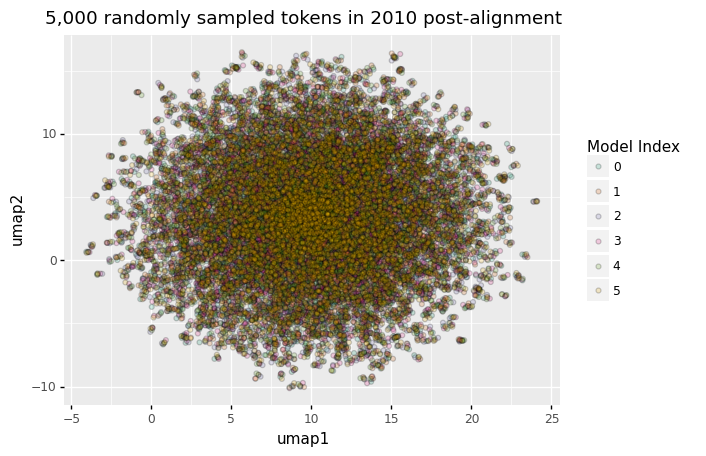

/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: output/figure_data_and_figures/aligned_2010_plot.svg
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: output/figure_data_and_figures/aligned_2010_plot.png


In [16]:
g = aligned_tok_df >> (
    p9.ggplot()
    + p9.aes(x="umap1", y="umap2", fill="year_label")
    + p9.geom_point(alpha=0.2)
    + p9.scale_fill_brewer(type="qual", palette="Dark2")
    + p9.labs(
        title=f"{tokens_sampled:,} randomly sampled tokens in {selected_year} post-alignment",
        fill="Model Index",
    )
)
print(g)
g.save(f"{str(output_file_folder)}/aligned_{selected_year}_plot.svg")
g.save(f"{str(output_file_folder)}/aligned_{selected_year}_plot.png", dpi=300)

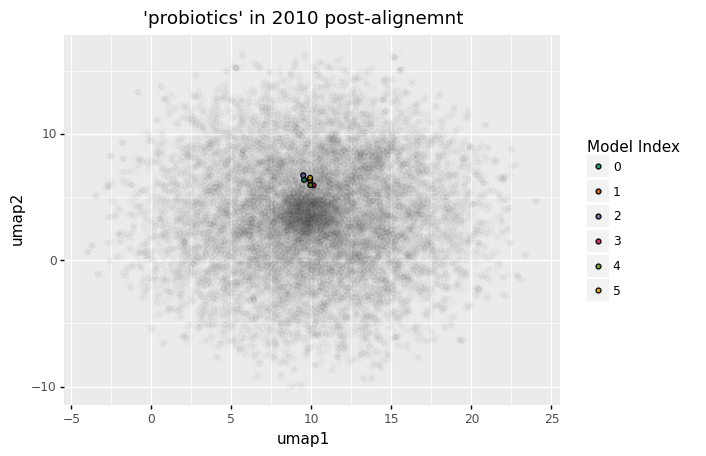

/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: output/figure_data_and_figures/aligned_2010_probiotics_plot.svg
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: output/figure_data_and_figures/aligned_2010_probiotics_plot.png


In [17]:
g = (
    aligned_tok_df
    >> ply.query(f"tok=='{example_tok}'")
    >> (
        p9.ggplot()
        + p9.aes(x="umap1", y="umap2", fill="year_label")
        + p9.geom_point()
        + p9.scale_fill_brewer(type="qual", palette="Dark2")
        + p9.geom_point(
            p9.aes(x="umap1", y="umap2"), data=aligned_tok_df, fill="grey", alpha=0.01
        )
        + p9.labs(
            title=f"'{example_tok}' in {selected_year} post-alignemnt",
            fill="Model Index",
        )
    )
)
print(g)
g.save(f"{str(output_file_folder)}/aligned_{selected_year}_{example_tok}_plot.svg")
g.save(
    f"{str(output_file_folder)}/aligned_{selected_year}_{example_tok}_plot.png", dpi=300
)